In [1]:
%load_ext autoreload
%autoreload 2

# Part 2. Build a forecasting model using a time-series analysis algorithm that will forecast the total sales revenue across all stores and items for the next 7 days

# 1. Data Preparation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
import joblib 
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

C:\Users\dlatl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_df = pd.read_csv('../data/raw/sales_train.csv')
test_df = pd.read_csv('../data/raw/sales_test.csv')
price_per_week = pd.read_csv('../data/raw/items_weekly_sell_prices.csv')
calendar = pd.read_csv('../data/raw/calendar.csv')
calendar_events = pd.read_csv('../data/raw/calendar_events.csv')

In [4]:
train_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1532,d_1533,d_1534,d_1535,d_1536,d_1537,d_1538,d_1539,d_1540,d_1541
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,1,0,1,0,1,0,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,8,2,0,8,2,3,1,1,3,8
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,0,1,3,2,1,1,2,2,3


In [5]:
test_df.head()

,d_1542,d_1543,d_1544,d_1545,d_1546,d_1547,d_1548,d_1549,d_1550,d_1551,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,0,1,0,2,1,0,2,0,1,0,...,2,4,0,0,0,0,3,3,0,1
1,0,0,0,0,0,0,0,0,1,0,...,0,1,2,1,1,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,4,1,0,1,3,5,2,3,0,2,...,1,1,0,4,0,1,3,0,2,6
4,3,0,0,1,1,0,2,0,2,1,...,0,0,0,2,1,0,0,2,1,0


In [6]:
price_per_week.head(10)

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
5,CA_1,HOBBIES_1_001,11330,8.26
6,CA_1,HOBBIES_1_001,11331,8.26
7,CA_1,HOBBIES_1_001,11332,8.26
8,CA_1,HOBBIES_1_001,11333,8.26
9,CA_1,HOBBIES_1_001,11334,8.26


In [7]:
price_per_week.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


In [8]:
calendar.head(14)

,date,wm_yr_wk,d
0,2011-01-29,11101,d_1
1,2011-01-30,11101,d_2
2,2011-01-31,11101,d_3
3,2011-02-01,11101,d_4
4,2011-02-02,11101,d_5
5,2011-02-03,11101,d_6
6,2011-02-04,11101,d_7
7,2011-02-05,11102,d_8
8,2011-02-06,11102,d_9
9,2011-02-07,11102,d_10


In [9]:
calendar.tail()

,date,wm_yr_wk,d
1964,2016-06-15,11620,d_1965
1965,2016-06-16,11620,d_1966
1966,2016-06-17,11620,d_1967
1967,2016-06-18,11621,d_1968
1968,2016-06-19,11621,d_1969


In [10]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      1969 non-null   object
 1   wm_yr_wk  1969 non-null   int64 
 2   d         1969 non-null   object
dtypes: int64(1), object(2)
memory usage: 46.3+ KB


In [11]:
calendar_events

,date,event_name,event_type
0,2011-02-06,SuperBowl,Sporting
1,2011-02-14,ValentinesDay,Cultural
2,2011-02-21,PresidentsDay,National
3,2011-03-09,LentStart,Religious
4,2011-03-16,LentWeek2,Religious
...,...,...,...
162,2016-05-30,MemorialDay,National
163,2016-06-02,NBAFinalsStart,Sporting
164,2016-06-07,Ramadan starts,Religious
165,2016-06-19,Father's day,Cultural


## 2. Merging Dataset & Data Cleaning

In [12]:
df = train_df.merge(test_df, left_index=True, right_index=True)
df

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,1,0,3,0,1,1,0,0,1,1
30486,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
30487,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,0,0,1,2,0,1,0,1,0,2
30488,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,1,1,1,4,6,0,1,1,1,0


In [13]:
df_melted = pd.melt(df, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'd', value_name = "sales")


In [14]:
calendar = calendar.merge(calendar_events, on= "date", how='left')
calendar

,date,wm_yr_wk,d,event_name,event_type
0,2011-01-29,11101,d_1,NaN,NaN
1,2011-01-30,11101,d_2,NaN,NaN
2,2011-01-31,11101,d_3,NaN,NaN
3,2011-02-01,11101,d_4,NaN,NaN
4,2011-02-02,11101,d_5,NaN,NaN
...,...,...,...,...,...
1969,2016-06-16,11620,d_1966,NaN,NaN
1970,2016-06-17,11620,d_1967,NaN,NaN
1971,2016-06-18,11621,d_1968,NaN,NaN
1972,2016-06-19,11621,d_1969,Father's day,Cultural


In [15]:
df = pd.merge(df_melted, calendar, on = "d")

In [16]:
df = pd.merge(df, price_per_week, on=['store_id','item_id','wm_yr_wk'], how='left') 
df

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,event_name,event_type,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,NaN,NaN,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,NaN,NaN,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,NaN,NaN,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,NaN,NaN,NaN
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59303045,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,d_1941,1,2016-05-22,11617,NaN,NaN,2.98
59303046,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,d_1941,0,2016-05-22,11617,NaN,NaN,2.48
59303047,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,d_1941,2,2016-05-22,11617,NaN,NaN,3.98
59303048,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,d_1941,0,2016-05-22,11617,NaN,NaN,1.28


In [17]:
df["revenues"] = df["sales"] * df["sell_price"]

In [57]:
df_forecast = df.groupby('date')["revenues"].sum().reset_index()
df_forecast

,date,revenues
0,2011-01-29,81650.61
1,2011-01-30,78970.57
2,2011-01-31,57706.91
3,2011-02-01,60761.20
4,2011-02-02,46959.95
...,...,...
1936,2016-05-18,116333.11
1937,2016-05-19,117456.32
1938,2016-05-20,134000.67
1939,2016-05-21,162395.65


In [19]:
calendar['event_name'] = calendar['event_name'].fillna('No Event')

In [58]:
df_forecast

,date,revenues
0,2011-01-29,81650.61
1,2011-01-30,78970.57
2,2011-01-31,57706.91
3,2011-02-01,60761.20
4,2011-02-02,46959.95
...,...,...
1936,2016-05-18,116333.11
1937,2016-05-19,117456.32
1938,2016-05-20,134000.67
1939,2016-05-21,162395.65


In [59]:
df_forecast = df_forecast.merge(calendar, on='date', how='left')
df_forecast

,date,revenues,wm_yr_wk,d,event_name,event_type
0,2011-01-29,81650.61,11101,d_1,No Event,NaN
1,2011-01-30,78970.57,11101,d_2,No Event,NaN
2,2011-01-31,57706.91,11101,d_3,No Event,NaN
3,2011-02-01,60761.20,11101,d_4,No Event,NaN
4,2011-02-02,46959.95,11101,d_5,No Event,NaN
...,...,...,...,...,...,...
1940,2016-05-18,116333.11,11616,d_1937,No Event,NaN
1941,2016-05-19,117456.32,11616,d_1938,No Event,NaN
1942,2016-05-20,134000.67,11616,d_1939,No Event,NaN
1943,2016-05-21,162395.65,11617,d_1940,No Event,NaN


In [60]:
df_forecast.drop(columns=['wm_yr_wk', 'd', 'event_type', 'event_name'], inplace = True)
df_forecast = df_forecast.rename(columns={'date': 'ds', 'revenues': 'y'})
df_forecast

,ds,y
0,2011-01-29,81650.61
1,2011-01-30,78970.57
2,2011-01-31,57706.91
3,2011-02-01,60761.20
4,2011-02-02,46959.95
...,...,...
1940,2016-05-18,116333.11
1941,2016-05-19,117456.32
1942,2016-05-20,134000.67
1943,2016-05-21,162395.65


In [61]:
df_forecast['ds'] = pd.to_datetime(df_forecast['ds'])

## 3. Train a Prophet Forecasting Model & Forecasting the total revenue for next 7 days

In [62]:
prophet = Prophet()


In [63]:
prophet.fit(df_forecast)
future = prophet.make_future_dataframe(periods=7)
forecast = prophet.predict(future)

20:08:50 - cmdstanpy - INFO - Chain [1] start processing
20:08:50 - cmdstanpy - INFO - Chain [1] done processing


In [65]:
future

,ds
0,2011-01-29
1,2011-01-30
2,2011-01-31
3,2011-02-01
4,2011-02-02
...,...
1943,2016-05-25
1944,2016-05-26
1945,2016-05-27
1946,2016-05-28


In [66]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2011-01-29,62301.805164,65768.944246,94621.397092,62301.805164,62301.805164,18594.479768,18594.479768,18594.479768,20166.284659,20166.284659,20166.284659,-1571.804891,-1571.804891,-1571.804891,0.0,0.0,0.0,80896.284932
1,2011-01-30,62354.328379,69784.268687,98765.315816,62354.328379,62354.328379,22202.236432,22202.236432,22202.236432,23500.806360,23500.806360,23500.806360,-1298.569928,-1298.569928,-1298.569928,0.0,0.0,0.0,84556.564811
2,2011-01-31,62406.851593,42134.408560,72139.055909,62406.851593,62406.851593,-5154.609395,-5154.609395,-5154.609395,-4145.991477,-4145.991477,-4145.991477,-1008.617918,-1008.617918,-1008.617918,0.0,0.0,0.0,57252.242198
3,2011-02-01,62459.374807,34660.489110,64498.627373,62459.374807,62459.374807,-12779.922581,-12779.922581,-12779.922581,-12078.173262,-12078.173262,-12078.173262,-701.749319,-701.749319,-701.749319,0.0,0.0,0.0,49679.452226
4,2011-02-02,62511.898021,34988.325730,63475.548732,62511.898021,62511.898021,-13527.411787,-13527.411787,-13527.411787,-13149.025451,-13149.025451,-13149.025451,-378.386337,-378.386337,-378.386337,0.0,0.0,0.0,48984.486234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1943,2016-05-25,133473.594272,105007.036007,134546.092745,133473.594272,133473.594272,-13616.742655,-13616.742655,-13616.742655,-13149.025451,-13149.025451,-13149.025451,-467.717204,-467.717204,-467.717204,0.0,0.0,0.0,119856.851616
1944,2016-05-26,133525.648914,104950.403605,136352.870103,133525.648914,133525.648914,-13063.533494,-13063.533494,-13063.533494,-12806.197821,-12806.197821,-12806.197821,-257.335672,-257.335672,-257.335672,0.0,0.0,0.0,120462.115420
1945,2016-05-27,133577.703556,117233.029457,146050.155381,133577.703556,133577.703556,-1495.781115,-1495.781115,-1495.781115,-1487.703009,-1487.703009,-1487.703009,-8.078106,-8.078106,-8.078106,0.0,0.0,0.0,132081.922441
1946,2016-05-28,133629.758198,139466.882205,167868.954906,133629.758198,133629.758198,20441.270445,20441.270445,20441.270445,20166.284659,20166.284659,20166.284659,274.985786,274.985786,274.985786,0.0,0.0,0.0,154071.028644


In [67]:
forecast_next_7_days = forecast[['ds', 'yhat']].tail(7)
forecast_next_7_days

,ds,yhat
1941,2016-05-23,128467.657451
1942,2016-05-24,120708.381400
1943,2016-05-25,119856.851616
1944,2016-05-26,120462.115420
1945,2016-05-27,132081.922441
1946,2016-05-28,154071.028644
1947,2016-05-29,157768.697432


In [68]:
def calculate_regression_metrics(y_test, pred):
    rmse = mean_squared_error(y_test, pred, squared=False)
    mse = mean_squared_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    metrics = {
        "RMSE": rmse,
        "MSE": mse,
        "R2": r2,
        "MAE": mae
    }
    return metrics

In [69]:

actual_value = df_forecast['y']
predicted_value = forecast['yhat'].iloc[: 1945 ,]

calculate_regression_metrics(actual_value, predicted_value)

{'RMSE': 24733.197399728913,
 'MSE': 611731053.613957,
 'R2': 0.05804874682937966,
 'MAE': 18823.069860299165}

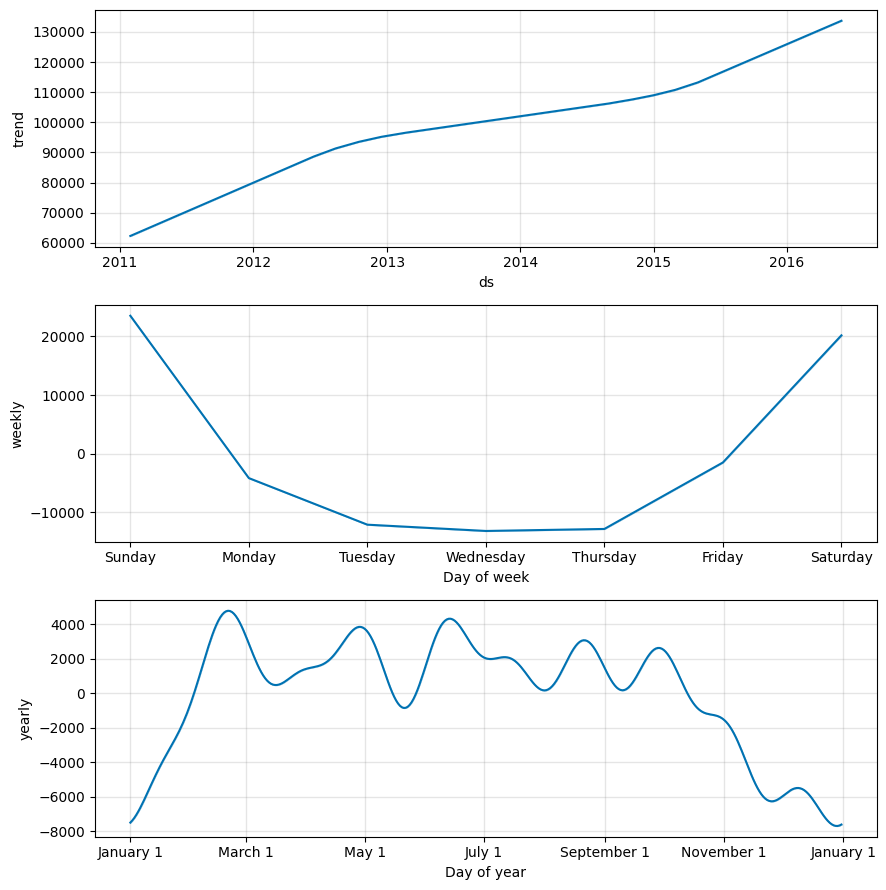

In [70]:
fig = prophet.plot_components(forecast)
plt.show()

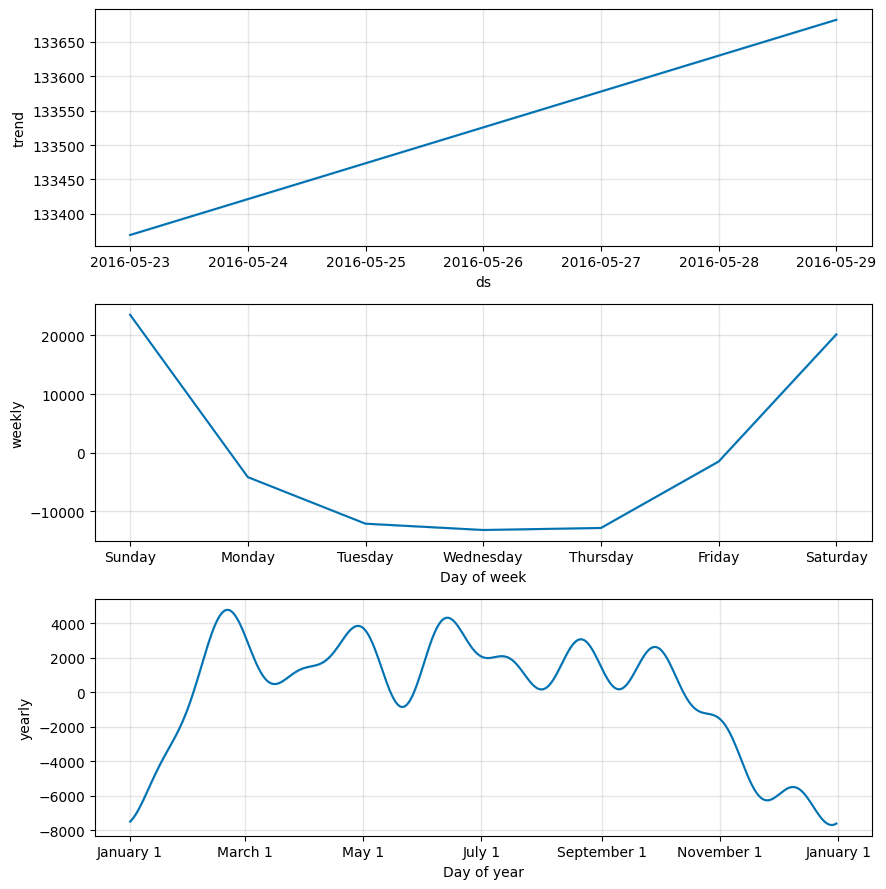

In [71]:
next_7_days = forecast.tail(7)
fig = prophet.plot_components(next_7_days)
plt.show()

In [72]:
joblib.dump(prophet, '../models/prophet_model.joblib')

['../models/prophet_model.joblib']